# Network analsys for SIR model

## Libraries

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import shutil
seed = np.random.seed(2137)
path_to_frames : Path = Path('../frames')
path_to_frames.mkdir(exist_ok=True)

## Visualization function

In [2]:
def draw_graph(G, pos, step, path_to_frames):
    plt.figure(figsize=(8, 6))
    state_color = {'S': 'blue', 'I': 'red', 'R': 'green'}
    colors = [state_color[G.nodes[n]['state']] for n in G.nodes()]
    nx.draw(G, pos, node_color=colors, node_size=25, width=0.5, with_labels=False, edge_color='gray')
    nx.draw_networkx_edges(G, pos, width=0.2, edge_color=(0, 0, 0, 0.1))
    plt.savefig(path_to_frames.joinpath(f'frame_{step}.png'))
    plt.close()

    
def plot_sir_data(results):
    plt.figure(figsize=(10, 8))
    for exp_id, result in results.items():
        history = result['history']
        S = [h['S'] for h in history]
        I = [h['I'] for h in history]
        R = [h['R'] for h in history]
        plt.plot(S, label=f'{exp_id} Susceptible')
        plt.plot(I, label=f'{exp_id} Infected')
        plt.plot(R, label=f'{exp_id} Recovered')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Nodes')
    plt.title('SIR Model Dynamics')
    plt.legend()
    plt.show()

## Progressing with infection

In [3]:
def create_gif(gif_name, duration=250, path_to_frames=Path('../frames')):
    frames = []
    for frame in sorted(path_to_frames.glob("*"), key=lambda x: int(x.name.split('_')[1].split('.')[0])):
        frames.append(Image.open(path_to_frames.joinpath(frame)))
    frames[0].save(gif_name, format='GIF', append_images=frames[1:], save_all=True, duration=duration, loop=0)

def update_graph(G):
    new_state = {}
    for node in G:
        if G.nodes[node]['state'] == 'I':
            # Try to infect neighbors
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['state'] == 'S' and np.random.random() < p:
                    new_state[neighbor] = 'I'
            # Recovery process
            if np.random.random() < q:
                new_state[node] = 'R'
    # Update states
    for node, state in new_state.items():
        G.nodes[node]['state'] = state

def count_states(G)-> dict:
    states = {'S': 0, 'I': 0, 'R': 0}
    for node in G.nodes:
        states[G.nodes[node]['state']] += 1
    return states

def simulate_sir(G, pos, p, tI, q, steps=500, snapshot_interval:int=50):
    # To keep track of S, I, R counts
    history:list = []
    # To keep track of graphs for snapshots
    snapshots:list = []
    for step in range(steps):
        update_graph(G)
        history.append(count_states(G))
        
        if step % snapshot_interval == 0 or step == steps - 1:
            plt.figure(figsize=(8, 6))
            draw_graph(G, pos, step, path_to_frames)
            # Save snapshot as PNG
            plt.savefig(f'snapshot_{step}.png')
            plt.close()
            snapshots.append(f'snapshot_{step}.png')
    return history, snapshots

def run_experiments(G, pos, experiments, steps=500, snapshot_interval=50):
    results = {}
    for exp_id, params in experiments.items():
        # Reset the graph to all susceptible
        nx.set_node_attributes(G, 'S', 'state')
        infected_nodes = np.random.choice(a=list(G.nodes()), size= params['i0'], replace=False)
        
        for node in infected_nodes:
            G.nodes[node]['state'] = 'I'
        
        history, snapshots = simulate_sir(G, pos, params['p'], params['tI'], params['q'], steps, snapshot_interval)
        results[exp_id] = {'history': history, 'snapshots': snapshots}
    return results

## Parameters and data

In [4]:
#? Probability of disease transmission
p:float = 0.05  
#? Minimum amount of time a node remains infected
tI:float = 3    
#? Probability of recovery
q:float = 0.1   
#? Initial number of infected individuals
i0:float = 5
DATA_PATH: Path = Path('../data/bn-mouse-kasthuri_graph_v4.edges')

print(f"Using dataset from {DATA_PATH.absolute()}")
# Create a small graph for testing
G = nx.read_edgelist(path=DATA_PATH, create_using=nx.Graph(), nodetype=int)
G.remove_edges_from(nx.selfloop_edges(G))
# Prunning the network from nodes with degree 1
G = nx.k_core(G, k=2)
print('nodes:', len(G.nodes()), 'and edges:', len(G.edges()))

Using dataset from c:\Users\szink\Desktop\programming\NetworkAnalysis\assignment2\src\..\data\bn-mouse-kasthuri_graph_v4.edges
nodes: 477 and edges: 1026


In [5]:
# Fix the position
pos = nx.spring_layout(G, seed=seed)
# Initialize all nodes to susceptible
nx.set_node_attributes(G, 'S', 'state')

In [6]:

# Define different experiments with varying parameters
experiments = {
    'exp1': {'p': 0.05, 'tI': 3, 'q': 0.1, 'i0': 5},
    'exp2': {'p': 0.1, 'tI': 5, 'q': 0.05, 'i0': 10},
    'exp3': {'p': 0.02, 'tI': 2, 'q': 0.2, 'i0': 20},
    'exp4': {'p': 0.15, 'tI': 3, 'q': 0.1, 'i0': 5},
    'exp5': {'p': 0.1, 'tI': 4, 'q': 0.15, 'i0': 25},
}
results = run_experiments(G, pos, experiments)

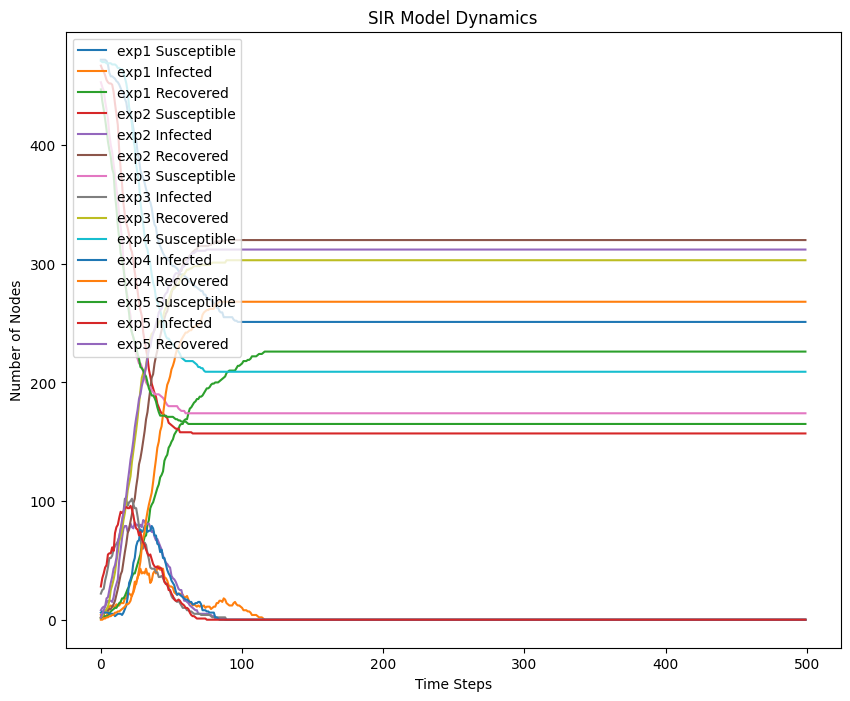

In [7]:
plot_sir_data(results)

# Create the GIF
create_gif('sir_simulation.gif', duration=500)
shutil.rmtree(path=path_to_frames)